# NaiveLiar
During the lecute we discussed the problem that a neural network is forced to lie when faced with an unknown input. That makes the NN a navie liar. In real applications the training set may be filtered and only within the specified categories, but the real data isn't. 




### What I'm trying to do
The easiest way to stop the NN from lying is to add another category. But that means changing the architecture of the network and retraining tha last layers. As that is ineffective, I don't wanna do that. Think about a scenario when we have a pretrained model, but no training dataset but are faced with the problem stated above.

I will add a post-processing layer that adds another category that will be chosen when the NN is unsure. I also will create an extended test set that will have randomly generated pictures in it for checking the improvements.

### Getting the engine warmed up

In [1]:

# Importing Packages

from IPython.display import display, clear_output
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

import tensorflow as tf 
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.12.0


### Getting the dataset ready

In [2]:
# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train_normalized = x_train / 255 
x_test_normalized = x_test /255

# reshaping
x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)

### Setting up the network

In [ ]:

# defining the architecture
merlin = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

merlin.summary()

# Define your loss
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

merlin.compile(optimizer='adam',
              loss = loss_fn ,
              metrics=['accuracy'])

I'm setting up a pretty basic NN. I played around with some layers to improve the confidence and therefore the effectiveness of my post-processing. It is important that the output layer is a softmax because that will be used later.

### Training

In [ ]:
# training Merlin

merlin.fit(
    x_train,
    y_train,
    epochs= 20,
    batch_size= 512 ,
    shuffle= True,
    validation_data=(x_test, y_test),
        callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),  
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)  
    ]
)

merlin.evaluate(x_test, y_test)

# saving Merlin
model_name = 'merlin.h5'
merlin.save(model_name, save_format='h5')

I didn't have to train merlin for long. I added some callbacks to stop the training process early to prevent overfitting. I noticed that when I trained merlin for over 30 epochs it got more sure about the random pictures as well, like he has "seen" something in them. That made the overall accuracy worse again.

I also saved merlin and did everything with the same model to research my approach.

### Loading the model for further testing

I have saved the model so everything should be reproducable.

In [ ]:
# load a saved merlin configuration you want to evaluate
model_name = 'merlin.h5'
merlin_reloaded = tf.keras.models.load_model(model_name)

merlin_reloaded.evaluate(x_test, y_test)

### Generate the extended dataset

In [50]:
# Generate random pictures for the "miscellaneous" category
num_miscellaneous_samples = 1000  
miscellaneous_images = np.random.rand(num_miscellaneous_samples, 28, 28, 1) 
miscellaneous_labels = np.full(num_miscellaneous_samples, 10)  # Labeling as 10

# Concatenate the miscellaneous data with the original test data
extended_x_test = np.concatenate([x_test, miscellaneous_images], axis=0)
extended_y_test = np.concatenate([y_test, miscellaneous_labels], axis=0)

# Shuffle test data
extended_data = list(zip(extended_x_test, extended_y_test))
np.random.shuffle(extended_data)
shuffled_extended_x_test, shuffled_extended_y_test = zip(*extended_data)
extended_x_test = np.array(shuffled_extended_x_test)
extended_y_test = np.array(shuffled_extended_y_test)


This is one core component of my reseaarch. I created an extended test data set by adding 1000 pictures where every pixel is random. This could theoretically generate every shape and form, like a number. But with such a small amount the chances are pretty low. I then shuffled the test data so the generated images are distributed over the dataset. So now about 9.1% of the dataset are random pictures.

See what happens when the AI is given something unknown:

In [ ]:
predictions_extended = merlin_reloaded.predict(extended_x_test)

for x in range(20):
    print("Softmax values:", predictions_extended[x], extended_y_test[x])

Before adding anything, I wanted to know what the NN does when confronted with something it wasn't trained on. As expected, the confidence distribution is more even and it isn't that sure what it is anymore. This is also to check if my extened test set is working.

### Adding custom post-processing

In [122]:
from tensorflow.keras import layers, models

class PostProcessing(layers.Layer):
    def __init__(self, threshold=0.2, **kwargs):
        super(PostProcessing, self).__init__(**kwargs)
        self.threshold = threshold

    def call(self, inputs):
        custom_category = tf.where(tf.reduce_max(inputs, axis=-1) < self.threshold, 1.0, 0.0)
        output = tf.concat([inputs, custom_category[..., tf.newaxis]], axis=-1)
        return output

# Adding the layer to merlin

merlin_with_postprocessing= models.Sequential([
    merlin_reloaded,
    PostProcessing(threshold=0.94)
])


merlin_with_postprocessing.compile(optimizer='adam',
              loss = loss_fn ,
              metrics=['accuracy'])


Now I add a post-processing layer to the already trained merlin. The call function creates a new category with the dimensions of the input vector and sets it to 1 if anything is below the threshold or to 0 if not. As the highest probability is chosen and the other values are always lower than 1, the custom category is chosen as true. I know this breaks the rule of the sum of probabilities being 1, but it also preserves the original values for analysis.

Just looking at the raw output to see if everything is alright

In [ ]:
predictions_extended = merlin_with_postprocessing.predict(extended_x_test)

for x in range(20):
    print("Values:", predictions_extended[x], extended_y_test[x])

### Comparing the accuracy when adding custom post-processing

In [ ]:
# compare standard to extended set
print("Standard set:")
print('shape', y_test.shape)
merlin_reloaded.evaluate(x_test, y_test)

print("Extended set with postprocessing, trying different thresholds:")
print('shape', extended_y_test.shape)

for x in range(100):
    merlin_with_postprocessing_test= models.Sequential([
    merlin_reloaded,
    AddCustomCategoryLayer(threshold=x/100)])

    merlin_with_postprocessing_test.compile(optimizer='adam',
              loss = loss_fn ,
              metrics=['accuracy'])
    print(x, "%")
    merlin_with_postprocessing_test.evaluate(extended_x_test, extended_y_test)

How the base NN worls on the original data set can be seen when setting the threshold to 0%, basically skipping the post-processing. With about 9% of the dataset being random we can see that the accuraacy also drops about 9% without post-processing to 89.87%.

By running this code the best threshold can be determined. With it set to 94% an accuracy of 95.75% can be achieved, which is 3.11% lower than the baseline. But comparing this to the performance of the baseline model on the altered data set, the added post-processing improves the accuracy by 5.88%. 

### Diving into the results
I just changed the code a bit so it woks with the added category.

344/344 [==============================] - 1s 4ms/step


C:\Users\mkram\AppData\Local\Temp\ipykernel_25856\3443767542.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


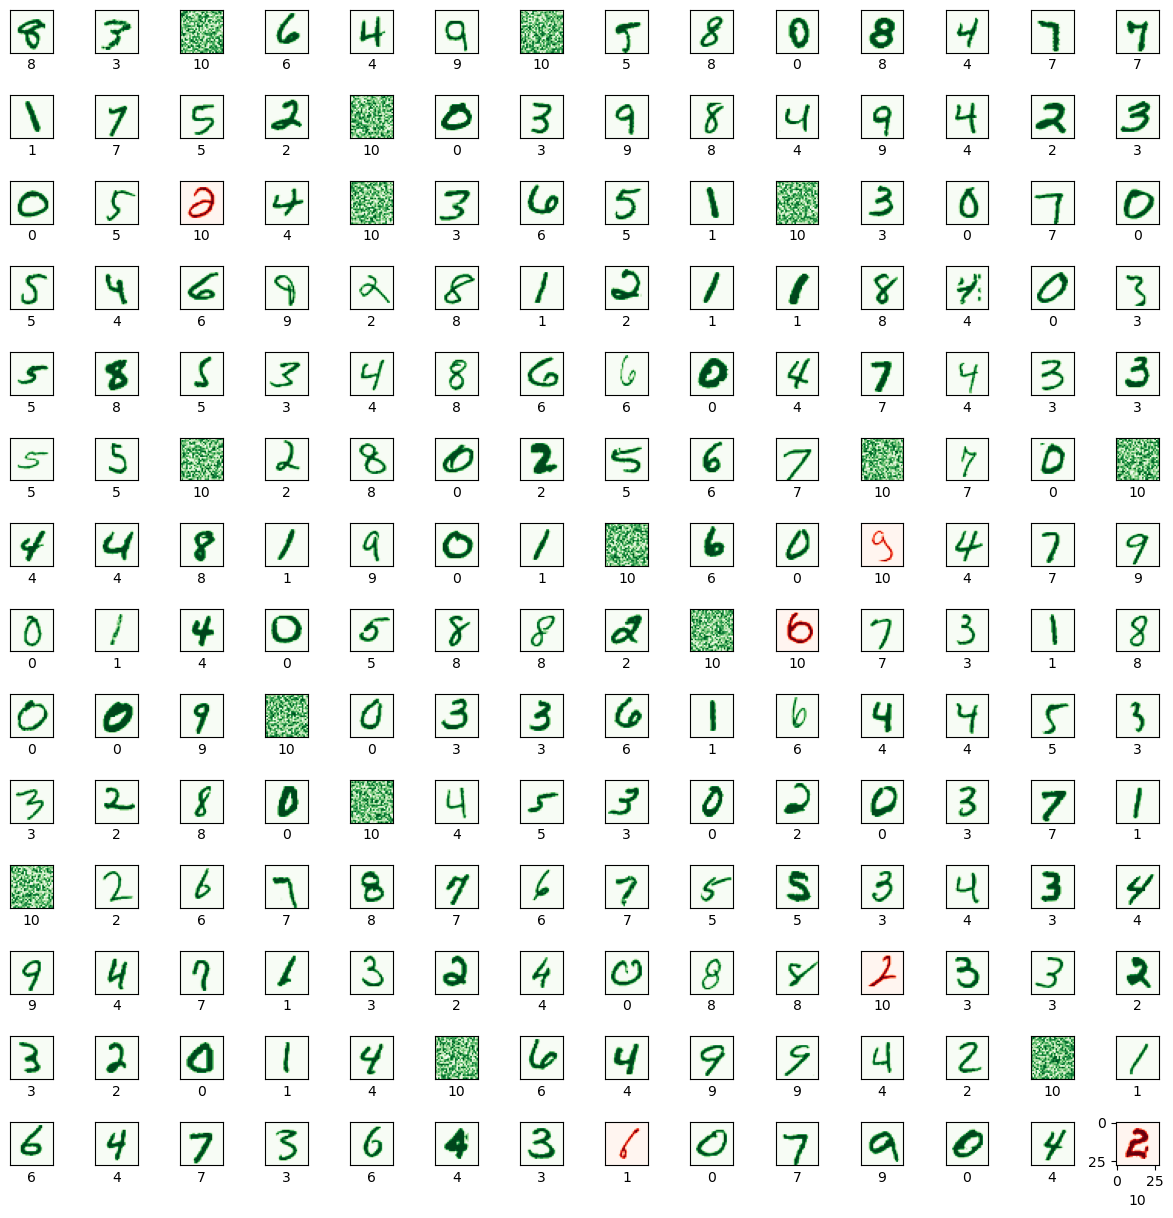

In [124]:
predictions = merlin_with_postprocessing.predict(extended_x_test)

# We want him to assign the digit class with the highest probability to the sample.
predictions = np.argmax(predictions, axis=1)
pd.DataFrame(predictions)

# Plot for the intuitive approach

numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):    
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == extended_y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(extended_x_test[plot_index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

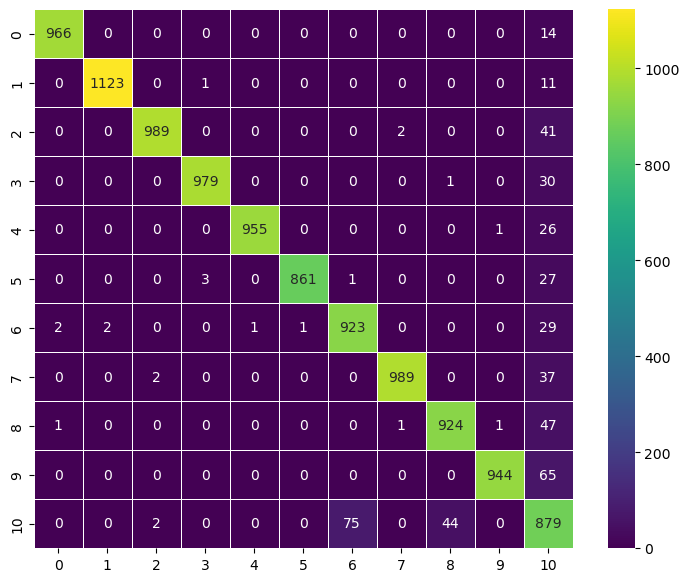

In [125]:
confusion_matrix = tf.math.confusion_matrix(extended_y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()

### Conclusion

As it can be seen in the improvement of the accuracy the post-processing works. But there are definitely better approaches to this problem that can determine if something is detectable. But as I am a programmer that still thinks in C++, this method seemed appealing to me. 

The confusion matrix shows that a lot of fale positives, but little to no false negatives. This suggests lowering the threshold. I have looked into this, but the false positives are not getting lower as fast as the false negatives go up.

The AI approach would be to train a NN to determine if my network is confused or not. The oputput of the confusion NN would either be a binaray indicator whether it's confused or all 11 cantegories. This would be very resource-heavy beut probably fun to try out some day.